# Netflix Shows

In this workbook we'll be anazlying trends between Netflix shows. We have a data set from Kaggle that has a plethora of information such as the actors, the director, the overall rating, what genre it is, and so on. Our goal is to

<u>Base Questions</u>
* Understanding what content is available in different countries
* Understanding how the number of TV shows and Movies on netflix has changed over time

<u>Deeper Questions</u>
* See if we can predict the rating of any particular movie given its details (genre, actors, etc)

>[Import the Data](#Import) <br>
[Initial Investingation](#Inv) <br>
[Question 1](#Q1)<br>
[Question 2](#Q2)

<a id='Import'></a>
## Import the Data

In [119]:
import pandas as pd
import numpy as np
import requests, io
from zipfile import ZipFile

import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

> To import the zip file into my directory I used Kaggles API and searched for the dataset using the command line. A quick search (`kaggle datasets list -s netflix`) revealed that the dataset I wanted was stored under `shivamb/netflix-shows`. Thus all I had to do to download the zip file to the directory I wanted was to type `kaggle datasets download shivamb/netflix-shows` to get the zip file downloaded in the directory

In [37]:
# Name of the zip file was found by inspecting the elements in our folder
local_zipfile = "netflix-shows.zip"

# Saving it to a new folder location with the name "netflix-shows"
with ZipFile(local_zipfile, 'r') as zipObj:
   # Extract all the contents of zip file in different directory
   zipObj.extractall(local_zipfile[:-4]) 

> Now we have the data from the zip file extracted and saved in a location called `netflix-shows`. There is one csv file in this folder called `netflix_titles_nov_2019.csv`, let's turn this into a data frame so we can do some initial investigation into the data

In [43]:
df = pd.read_csv('netflix-shows/netflix_titles_nov_2019.csv')
df.head()

,show_id,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,type
0,81193313,Chocolate,NaN,"Ha Ji-won, Yoon Kye-sang, Jang Seung-jo, Kang ...",South Korea,"November 30, 2019",2019,TV-14,1 Season,"International TV Shows, Korean TV Shows, Roman...",Brought together by meaningful meals in the pa...,TV Show
1,81197050,Guatemala: Heart of the Mayan World,"Luis Ara, Ignacio Jaunsolo",Christian Morales,NaN,"November 30, 2019",2019,TV-G,67 min,"Documentaries, International Movies","From Sierra de las Minas to Esquipulas, explor...",Movie
2,81213894,The Zoya Factor,Abhishek Sharma,"Sonam Kapoor, Dulquer Salmaan, Sanjay Kapoor, ...",India,"November 30, 2019",2019,TV-14,135 min,"Comedies, Dramas, International Movies",A goofy copywriter unwittingly convinces the I...,Movie
3,81082007,Atlantics,Mati Diop,"Mama Sane, Amadou Mbow, Ibrahima Traore, Nicol...","France, Senegal, Belgium","November 29, 2019",2019,TV-14,106 min,"Dramas, Independent Movies, International Movies","Arranged to marry a rich man, young Ada is cru...",Movie
4,80213643,Chip and Potato,NaN,"Abigail Oliver, Andrea Libman, Briana Buckmast...","Canada, United Kingdom",NaN,2019,TV-Y,2 Seasons,Kids' TV,"Lovable pug Chip starts kindergarten, makes ne...",TV Show


<a id ='Inv'></a>
## Initial Investingation

In [47]:
df.shape #relatively small dataset

(5837, 12)

In [48]:
df.info() #Not too much missing info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5837 entries, 0 to 5836
Data columns (total 12 columns):
show_id         5837 non-null int64
title           5837 non-null object
director        3936 non-null object
cast            5281 non-null object
country         5410 non-null object
date_added      5195 non-null object
release_year    5837 non-null int64
rating          5827 non-null object
duration        5837 non-null object
listed_in       5837 non-null object
description     5837 non-null object
type            5837 non-null object
dtypes: int64(2), object(10)
memory usage: 547.3+ KB


In [50]:
df['type'].value_counts()

Movie      3939
TV Show    1898
Name: type, dtype: int64

In [58]:
print('There are ' + str(len(df['country'].value_counts().index.tolist())) + ' countries with netflix shows/movies')

There are 527 countries with netflix shows/movies


<a id='Q1'></a>
## Question 1

What content is available in different countries? (Tv shows vs. movies)
* To answer this let's only look at countries that have more than 5 netflix shows/movies; there were a lot of countries with only 1 put out

In [174]:
# Making a copy to mess around with. Drop irrelevant columns and rows with Null values for the country.
countries_df = df.copy()
column_list = ['title', 'director', 'cast', 'date_added', 'release_year', 'rating', 'duration', 'listed_in', 'description']
countries_df = countries_df.drop(column_list, axis = 1)
countries_df = countries_df[countries_df['country'].notnull()]
countries_df.head()

,show_id,country,type
0,81193313,South Korea,TV Show
2,81213894,India,Movie
3,81082007,"France, Senegal, Belgium",Movie
4,80213643,"Canada, United Kingdom",TV Show
5,81172754,Nigeria,Movie


In [171]:
# For entries with multiple countries for a production, we want to give every country credit for this. Lets divide
# up the entries with multiple countries into multiple rows
country_df = pd.DataFrame(countries_df.country.str.split(',').tolist(), index=countries_df.show_id).stack()
country_df = country_df.reset_index([0, 'show_id'])
country_df.head()


# Unfortunately splitting up the string caused issues with white spaces. This next block was designed to deal with
# making " USA" turn into "USA" for example
clean_country_list = []
full_list = countries_df.country.str.split(',').tolist()
for i in full_list:
    for ii in i:
        j = ii.replace(' ','')
        clean_country_list.append(j)

# Replacing the country list with 
country_df[0] = clean_country_list
country_df.head()

,show_id,0
0,81193313,SouthKorea
1,81213894,India
2,81082007,France
3,81082007,Senegal
4,81082007,Belgium


In [172]:
# Now we want to join the movie type to this table. A simple merge will do, drop the extra country column,
# and rename the '0' column to country for more clarity
country_count_df = pd.merge(country_df, countries_df, left_on='show_id', right_on='show_id', how='left').drop('country', axis = 1).rename(columns={0: "country"})
plot_country_df = country_count_df.drop('show_id', axis = 1)
plot_country_df.head(10)

,country,type
0,SouthKorea,TV Show
1,India,Movie
2,France,Movie
3,Senegal,Movie
4,Belgium,Movie
5,Canada,TV Show
6,UnitedKingdom,TV Show
7,Nigeria,Movie
8,France,Movie
9,SouthAfrica,Movie


In [233]:
# Now lets only keep countries with at least 10 productions
g = len(plot_country_df.groupby('country').filter(lambda x: len(x) >= 5).country.value_counts().index.tolist())
print('Sadly there are still ' + str(g) + ' countries with over 5 productions so let\'s try 50.\n')

g2 = len(plot_country_df.groupby('country').filter(lambda x: len(x) >= 100).country.value_counts().index.tolist())
print('There are ' + str(g2) + ' countries with 100 productions or more. Let\'s use only these countries')

# Just to compare, lets take the top producing countries and the "middle" producing countries (at least 20 productions)
top_countries = plot_country_df.groupby('country').filter(lambda x: len(x) >= 100).country.value_counts().index.tolist()
middle_countries = plot_country_df.groupby('country').filter(lambda x: len(x) >= 20).country.value_counts().index.tolist()[-10:]


Sadly there are still 55 countries with over 5 productions so let's try 50.

There are 12 countries with 100 productions or more. Let's use only these countries


['UnitedStates',
 'India',
 'UnitedKingdom',
 'Canada',
 'France',
 'Japan',
 'Spain',
 'SouthKorea',
 'Germany',
 'Mexico',
 'Australia',
 'China']

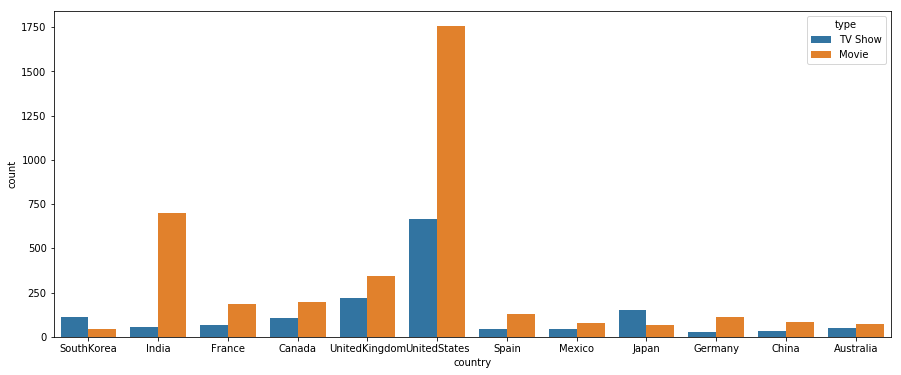

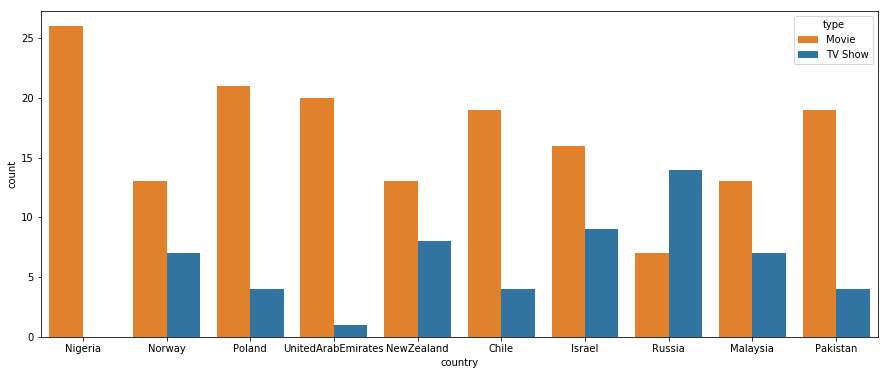

In [243]:
# Now we can make some visuals to see this data
base_color = sb.color_palette()[0]

top_country_count_df = country_count_df[country_count_df['country'].isin(top_countries)]
middle_country_count_df = country_count_df[country_count_df['country'].isin(middle_countries)]

plt.figure(figsize = (15,6))
palette ={"TV Show":"C0","Movie":"C1"}
sb.countplot(data = top_country_count_df, x = 'country', hue = 'type', palette=palette);
plt.xlabel('Country');
plt.title('Top Countries Distribution');
plt.figure(figsize = (15,6))
sb.countplot(data = middle_country_count_df, x = 'country', hue = 'type', palette=palette);
plt.xlabel('Country');
plt.title('Middle Countries Distribution');

> Thus as we can tell, <b> pretty much universally all these countries have more movies than TV shows!</b> That's honestly not what I was expecting considering I mainly use netflix for TV shows. However this categorization does not take into account other categories like for example stand up comedians. I believe that would not necessarily fall into either of these categories and yet they must have been classified in one of the two somehow

<a id='Q2'></a>
## Question 2

Understanding how the number of TV shows and Movies on netflix has changed over time

> In order to do this we can first have to bin the data into time bins and then we can track how the movies/tv prodction has changed over time

In [267]:
# Let's first make a copy of the originial data frame with
date_df = df[df.date_added.isnull() == False]
year_added = pd.to_datetime(date_df.date_added).dt.year;
year_added.value_counts()

2019    1843
2018    1629
2017    1184
2016     412
2015      74
2014      19
2011      13
2013       9
2012       7
2009       2
2008       2
2010       1
Name: date_added, dtype: int64

In [253]:
# Gets us a base look at the time spread
df.release_year.value_counts()

# Let's just keep the years past 1990. (1990-2019)
years = np.arange(1990, 2019, 1).tolist()
years_df = df[df['release_year'].isin(years)]
years_df.head()

# Eliminate irrelevant columns
column_list = ['title', 'director', 'cast', 'release_year', 'country', 'rating', 'duration', 'listed_in', 'description']
years


,show_id,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,type
5,81172754,Crazy people,Moses Inwang,"Ramsey Nouah, Chigul, Sola Sobowale, Ireti Doy...",Nigeria,"November 29, 2019",2018,TV-14,107 min,"Comedies, International Movies, Thrillers",Nollywood star Ramsey Nouah learns that someon...,Movie
7,81227195,Kalushi: The Story of Solomon Mahlangu,Mandla Dube,"Thabo Rametsi, Thabo Malema, Welile Nzuza, Jaf...",South Africa,"November 29, 2019",2016,TV-MA,107 min,"Dramas, International Movies",The life and times of iconic South African lib...,Movie
9,81172841,Lagos Real Fake Life,Mike Ezuruonye,"Nonso Diobi, Mike Ezuruonye, Mercy Aigbe, Rex ...",NaN,"November 29, 2019",2018,TV-14,118 min,"Comedies, International Movies",Two mooching friends vie for the attention of ...,Movie
10,81172899,Payday,Cheta Chukwu,"Baaj Adebule, Ebiye Victor, Meg Otanwa, Bisola...",Nigeria,"November 29, 2019",2018,TV-MA,110 min,"Comedies, Independent Movies, International Mo...","After an expensive night out, two flatmates ge...",Movie
12,81172908,The Accidental Spy,Roger Russell,"Ramsey Nouah, Christine Allado, Ayo Makun, Emm...",Nigeria,"November 29, 2019",2017,TV-14,104 min,"Action & Adventure, Comedies, International Mo...","Nursing a broken heart, an IT specialist moves...",Movie
